In [8]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt

In [2]:

# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=IBM&interval=5min&apikey=demo'
r = requests.get(url)
data = r.json()



In [3]:
ticker = "IBM"
internval = ["1min", "5min", "15min", "30min", "60min"]
apikey = "T87YP0BT9VVE1VC6"
period_slice = "year1month3"

In [4]:
def AlphaVantageDataPull(ticker, interval, apikey, period_slice):
    url = 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={sym}&interval={inter}&apikey={key}&slice={period_slice}'.format(sym = ticker,
                                                                                                                                                  inter = interval,
                                                                                                                                                  key = apikey,
                                                                                                                                                 period_slice=period_slice)
    r = requests.get(url)
    data = r.json()
    
    return data

In [5]:
test_data = AlphaVantageDataPull(ticker, internval[4], apikey, period_slice)

In [10]:
test_data['Time Series (60min)'].keys()

dict_keys(['2023-03-28 20:00:00', '2023-03-28 18:00:00', '2023-03-28 17:00:00', '2023-03-28 16:00:00', '2023-03-28 15:00:00', '2023-03-28 14:00:00', '2023-03-28 13:00:00', '2023-03-28 12:00:00', '2023-03-28 11:00:00', '2023-03-28 10:00:00', '2023-03-28 09:00:00', '2023-03-27 20:00:00', '2023-03-27 19:00:00', '2023-03-27 18:00:00', '2023-03-27 17:00:00', '2023-03-27 16:00:00', '2023-03-27 15:00:00', '2023-03-27 14:00:00', '2023-03-27 13:00:00', '2023-03-27 12:00:00', '2023-03-27 11:00:00', '2023-03-27 10:00:00', '2023-03-27 09:00:00', '2023-03-27 08:00:00', '2023-03-24 19:00:00', '2023-03-24 18:00:00', '2023-03-24 17:00:00', '2023-03-24 16:00:00', '2023-03-24 15:00:00', '2023-03-24 14:00:00', '2023-03-24 13:00:00', '2023-03-24 12:00:00', '2023-03-24 11:00:00', '2023-03-24 10:00:00', '2023-03-24 09:00:00', '2023-03-24 08:00:00', '2023-03-24 07:00:00', '2023-03-24 06:00:00', '2023-03-23 20:00:00', '2023-03-23 18:00:00', '2023-03-23 17:00:00', '2023-03-23 16:00:00', '2023-03-23 15:00:00', 

In [11]:
test_data['Time Series (15min)']['2023-03-28 20:00:00']['4. close']

KeyError: 'Time Series (15min)'

In [12]:
hourly_data = []

for i in test_data['Time Series (60min)'].keys():
    hourly_data.append((i, test_data['Time Series (60min)'][i]['4. close']))

print(hourly_data)

[('2023-03-28 20:00:00', '129.2700'), ('2023-03-28 18:00:00', '129.1100'), ('2023-03-28 17:00:00', '129.3000'), ('2023-03-28 16:00:00', '129.3300'), ('2023-03-28 15:00:00', '129.1100'), ('2023-03-28 14:00:00', '129.0100'), ('2023-03-28 13:00:00', '129.3100'), ('2023-03-28 12:00:00', '129.4900'), ('2023-03-28 11:00:00', '129.3100'), ('2023-03-28 10:00:00', '129.3200'), ('2023-03-28 09:00:00', '129.3100'), ('2023-03-27 20:00:00', '129.5600'), ('2023-03-27 19:00:00', '129.7200'), ('2023-03-27 18:00:00', '129.3500'), ('2023-03-27 17:00:00', '129.3200'), ('2023-03-27 16:00:00', '129.3500'), ('2023-03-27 15:00:00', '130.0000'), ('2023-03-27 14:00:00', '129.7200'), ('2023-03-27 13:00:00', '129.3100'), ('2023-03-27 12:00:00', '128.9800'), ('2023-03-27 11:00:00', '128.2300'), ('2023-03-27 10:00:00', '128.2050'), ('2023-03-27 09:00:00', '125.6621'), ('2023-03-27 08:00:00', '126.0000'), ('2023-03-24 19:00:00', '125.5500'), ('2023-03-24 18:00:00', '125.2924'), ('2023-03-24 17:00:00', '125.5700'), 

In [19]:
ibm_hist = pd.DataFrame(hourly_data, columns=['time', 'price'])
ibm_hist['price'] = ibm_hist['price'].astype(float)
ibm_hist['time'] = pd.to_datetime(ibm_hist['time'])

In [20]:
ibm_hist.dtypes

time     datetime64[ns]
price           float64
dtype: object

In [21]:
ibm_hist.describe()

,price
count,100.000000
mean,125.774269
std,2.157151
min,122.800000
25%,123.845000
50%,125.440000
75%,126.765000
max,130.000000


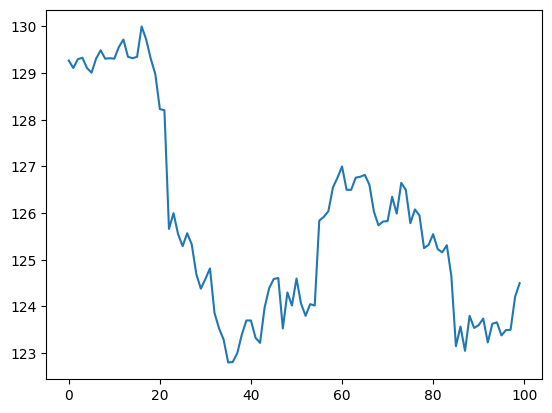

In [24]:
plt.plot(ibm_hist['price'], )

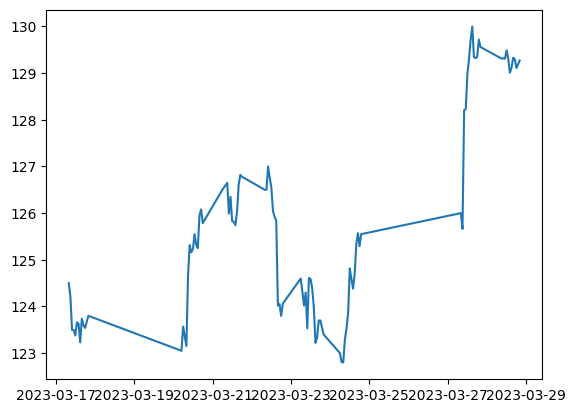

In [25]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(ibm_hist['time'], ibm_hist['price'], color='tab:blue')

In [35]:
ibm_hist['is_test'] = np.where(ibm_hist['time'] > ibm_hist[:20]['time'][19], 1, 0)

In [37]:
ibm_hist.head(50)

,time,price,is_test
0,2023-03-28 20:00:00,129.2700,1
1,2023-03-28 18:00:00,129.1100,1
2,2023-03-28 17:00:00,129.3000,1
3,2023-03-28 16:00:00,129.3300,1
4,2023-03-28 15:00:00,129.1100,1
5,2023-03-28 14:00:00,129.0100,1
6,2023-03-28 13:00:00,129.3100,1
7,2023-03-28 12:00:00,129.4900,1
8,2023-03-28 11:00:00,129.3100,1
9,2023-03-28 10:00:00,129.3200,1


In [47]:
np.mean(ibm_hist[ibm_hist.is_test==0]['price'].values)

124.92872716049385

In [48]:
avg_model_1 = np.mean(ibm_hist[ibm_hist.is_test==0]['price'].values)

In [49]:
ibm_hist['avg_model_pred'] = avg_model_1

In [50]:
ibm_hist

,time,price,is_test,avg_model_pred
0,2023-03-28 20:00:00,129.270,1,124.928727
1,2023-03-28 18:00:00,129.110,1,124.928727
2,2023-03-28 17:00:00,129.300,1,124.928727
3,2023-03-28 16:00:00,129.330,1,124.928727
4,2023-03-28 15:00:00,129.110,1,124.928727
...,...,...,...,...
95,2023-03-17 12:00:00,123.380,0,124.928727
96,2023-03-17 11:00:00,123.495,0,124.928727
97,2023-03-17 10:00:00,123.500,0,124.928727
98,2023-03-17 09:00:00,124.210,0,124.928727


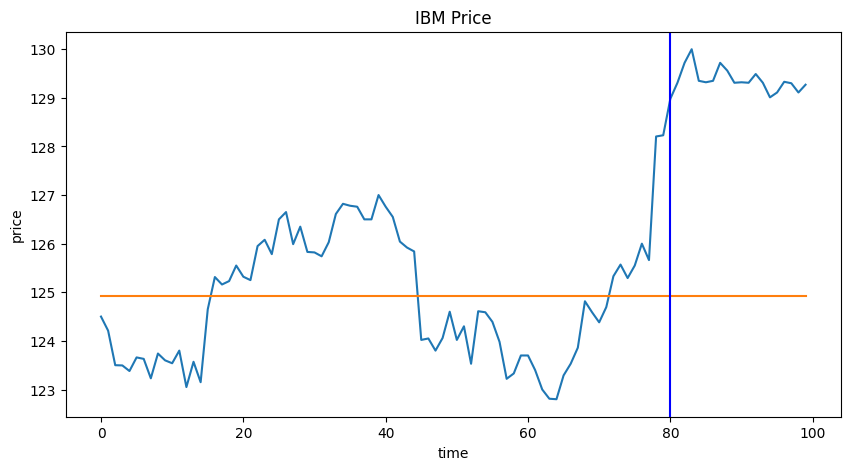

In [64]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.plot(ibm_hist['price'][::-1].values)
plt.plot(ibm_hist['avg_model_pred'][::-1].values)
plt.axvline(x = 80, color = 'b', label = 'axvline - full height')
plt.title('IBM Price')
plt.xlabel("time")
plt.ylabel("price")
plt.show()

In [62]:
ibm_hist['price'][::-1]

99    124.500
98    124.210
97    123.500
96    123.495
95    123.380
       ...   
4     129.110
3     129.330
2     129.300
1     129.110
0     129.270
Name: price, Length: 100, dtype: float64

In [67]:
ibm_hist['sq_error'] = (ibm_hist['price'] - ibm_hist['avg_model_pred'])**2

In [73]:
oos_mse = np.mean(ibm_hist[ibm_hist['is_test']==1]['sq_error'])

In [74]:
oos_mse

19.85669036995779

In [70]:
insample_mse = np.mean(ibm_hist[ibm_hist['is_test']==0]['sq_error'])

In [71]:
insample_mse

1.912267196793171